# Trabalho da disciplina Ferramentas de Softwares para uso em Ciência de Dados II
Professor: Marcos Guimarães<br>
Aluno: Wanderson Diego de Melo Torres<br>
Março / 2019

## Análise exploratória de filmes do TMDB

In [53]:
import numpy as np 
import pandas as pd 
import json
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image
% matplotlib inline

In [54]:
# carregando os datasets
df_movies = pd.read_csv("../input/tmdb_5000_movies.csv")
df_credits = pd.read_csv("../input/tmdb_5000_credits.csv")

In [55]:
# explorando os dados dos filmes
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [56]:
# Explorando os dados dos créditos dos filmes
df_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [57]:
# Renomeia a coluna id
df_credits.columns = ['id', 'title', 'cast', 'crew']

# Exclui a coluna 'title' que está repetida nas duas bases
df_credits.drop(columns=['title'], inplace=True)

# junta as duas bases em uma só, pelo ID
df_movies = df_movies.merge(df_credits, on='id')
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [58]:
# forma do novo dataframe
df_movies.shape

(4803, 22)

In [59]:
# colunas do novo dataframe
df_movies.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

In [60]:
# converte o tipo de dados da coluna status para category
df_movies.status = df_movies.status.astype('category')
df_movies.status.dtype

CategoricalDtype(categories=['Post Production', 'Released', 'Rumored'], ordered=False)

In [61]:
# converte o tipo de dados das colunas de data
df_movies.release_date = pd.to_datetime(df_movies.release_date)

In [62]:
# Explorando os dados de colunas com valores em formato json
df_movies['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [63]:
df_movies['keywords'][0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [64]:
df_movies['production_companies'][0]

'[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]'

In [65]:
df_movies['production_countries'][0]

'[{"iso_3166_1": "US", "name": "United States of America"}, {"iso_3166_1": "GB", "name": "United Kingdom"}]'

In [66]:
df_movies['spoken_languages'][0]

'[{"iso_639_1": "en", "name": "English"}, {"iso_639_1": "es", "name": "Espa\\u00f1ol"}]'

In [67]:
# Faz o parse dos campos definidos em features para os seus correspondentes em python
features = ['cast', 'crew', 'keywords', 'genres', 'production_companies', 'spoken_languages', 'production_countries']
for feature in features:
    df_movies[feature] = df_movies[feature].apply(literal_eval)
    
# Método que recupera o diretor do filme
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# Retorna uma lista dos primeiros n elementos (informado por parâmetro) ou a lista inteira se for menor
# Argumento 1: nome do campo, valor padrão: name
# Argumento 2: máximo de elementos a serem retornados, valor padrão: 5
def get_list(x, *args):
    if len(args) == 0:
        field = 'name'
        max_list = 5
    elif len(args) == 1:
        field = args[0]
        max_list = 5
    elif len(args) == 2:
        field = args[0]
        max_list = args[1]
        
    if isinstance(x, list):
        names = [i[field] for i in x]
        if len(names) > max_list:
            names = names[:max_list]
        return names

    # Retorna uma lista vazia em caso de falta dos dados ou de dados mal formados
    return []

In [68]:
# Acrescenta uma coluna com o nome do diretor 
df_movies['director'] = df_movies['crew'].apply(get_director)

In [69]:
# Acrescenta uma coluna com o ano de lançamento
df_movies['release_year'] = df_movies['release_date'].dt.year

In [70]:
# Converte o campos genres, keywords, production_companies, spoken_languages e production_countries em listas
df_movies['genres'] = df_movies['genres'].apply(get_list)
df_movies['keywords'] = df_movies['keywords'].apply(get_list, args=('name',))
df_movies['production_companies'] = df_movies['production_companies'].apply(get_list, args=('name',))
df_movies['spoken_languages'] = df_movies['spoken_languages'].apply(get_list, args=('iso_639_1',))
df_movies['production_countries'] = df_movies['production_countries'].apply(get_list, args=('name',))
df_movies['cast'] = df_movies['cast'].apply(get_list, args=('name', 10,))

In [71]:
df_movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,release_year
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4802.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,2002.468763
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,12.414354
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1916.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,1999.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,2005.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,2011.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,2017.000000


### Orçamento x Receita

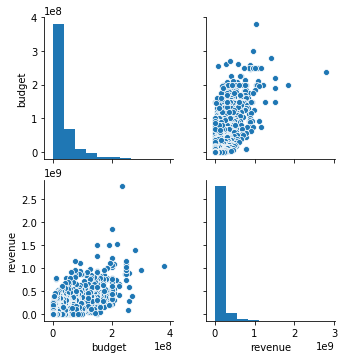

In [72]:
# Relação entre orçamento e receita
sns.pairplot(df_movies[['budget', 'revenue']])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


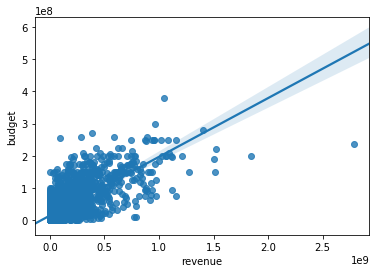

In [73]:
sns.regplot(x="revenue", y="budget", data=df_movies);

A relação entre orçamento x receita mostra uma certa linearidade entre essas duas variáveis. Quanto maior o orçamento, maior a receita do filme.

### Diretores que produziram mais filmes

In [74]:
df_movies['director'].value_counts().nlargest(10)

Steven Spielberg     27
Woody Allen          21
Martin Scorsese      20
Clint Eastwood       20
Ridley Scott         16
Robert Rodriguez     16
Spike Lee            16
Steven Soderbergh    15
Renny Harlin         15
Oliver Stone         14
Name: director, dtype: int64

Steven Spielberg foi o diretor mais relevante, dirigindo 27 filmes. 6 a mais que o segundo colocado.

### Keywords que mais apareceram

In [75]:
# Gera uma string separada por virgula das keywords dos filmes
words = []
df_movies['keywords'].apply(lambda x: words.extend(x))
words = ','.join(words)

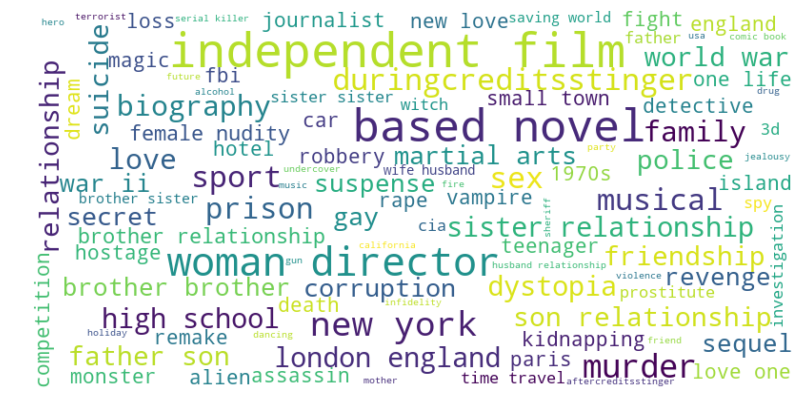

In [76]:
# Gera uma nuvem de palavras com as keywords mais utilizadas
words_sep = words.replace(' ', '~')
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=800, height=400).generate(words_sep)

# Display the generated image:
plt.figure( figsize=(17,7) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

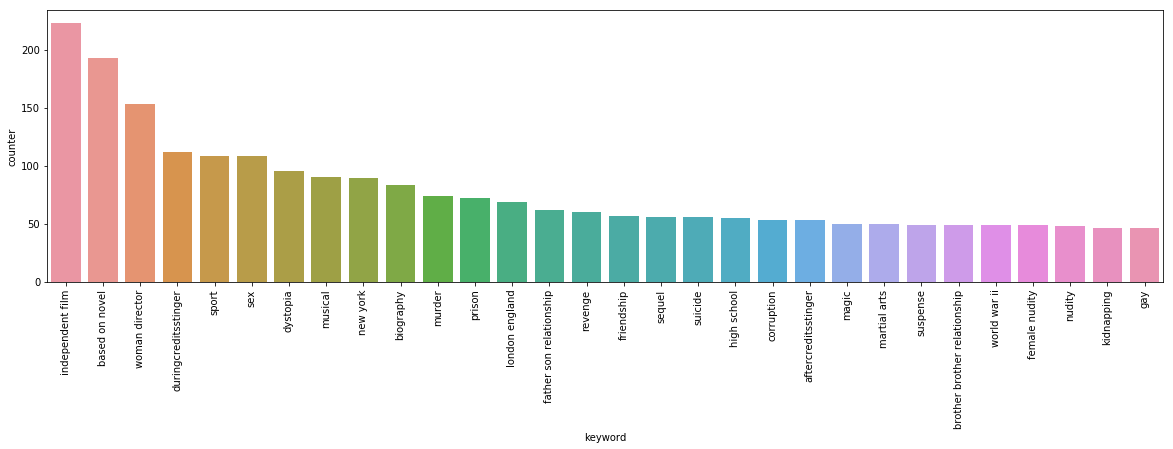

In [77]:
common_keywords = Counter(words.split(',')).most_common(30)
df_common_keywords = pd.DataFrame(common_keywords, columns=['keyword', 'counter'])
plt.figure( figsize=(20,5) )
barplot = sns.barplot(x=df_common_keywords['keyword'], y=df_common_keywords['counter'])
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
plt.show()

Três keywords apareceram mais que as demais: 'independent film', 'based on novel' e 'duringcreditsstinger'.

### Atores que mais atuaram

In [87]:
words = []
df_movies['cast'].apply(lambda x: words.extend(x))
actors_counter = Counter(words).most_common(10)
df_actors_counter = pd.DataFrame(actors_counter, columns=['name', 'counter'])
df_actors_counter

,name,counter
0,Samuel L. Jackson,58
1,Robert De Niro,55
2,Morgan Freeman,46
3,Bruce Willis,42
4,Matt Damon,41
5,Steve Buscemi,37
6,Brad Pitt,37
7,Nicolas Cage,37
8,Alec Baldwin,37
9,Johnny Depp,36


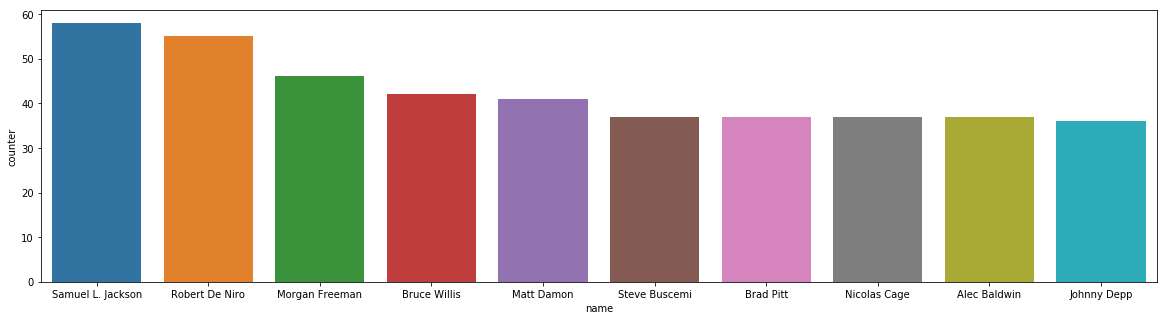

In [79]:
plt.figure( figsize=(20,5) )
sns.barplot(x=df_actors_counter['name'], y=df_actors_counter['counter'])
#barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
#plt.show()

### Popularidade x Receita

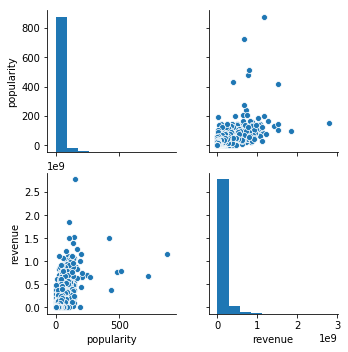

In [80]:
sns.pairplot(df_movies[['popularity', 'revenue']])

É possível observar uma linearidade entre popularidade e receita, mas também há alguns outliers que fogem a essa linearidade.

### Popularidade x Runtime

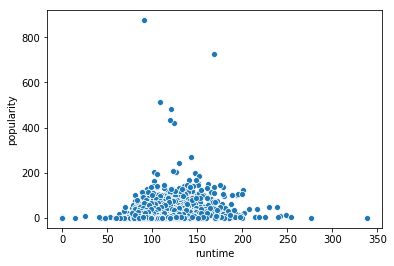

In [81]:
sns.scatterplot(x=df_movies['runtime'], y=df_movies['popularity'])

### Custo x Runtime

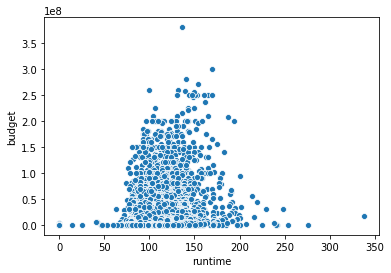

In [82]:
sns.scatterplot(x=df_movies['runtime'], y=df_movies['budget'])

### Gêneros mais populares

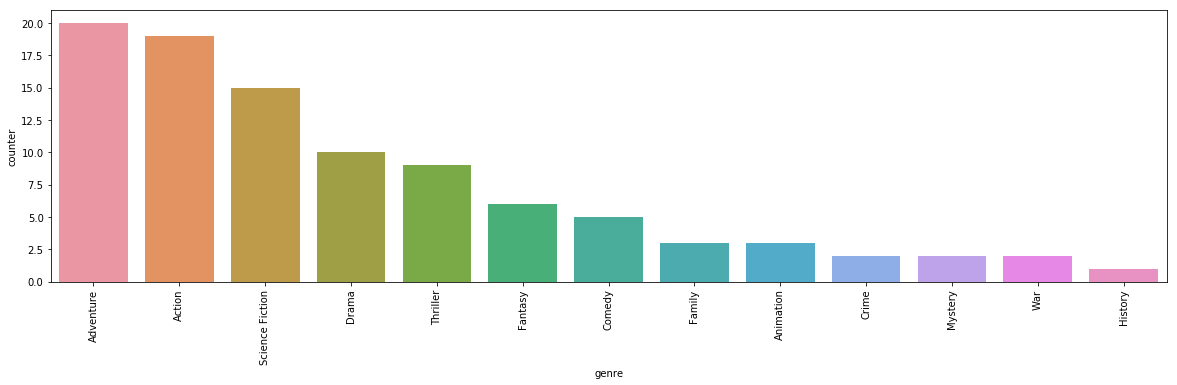

In [83]:
# Pega os 30 filmes com popularidade mais alta
df_popular = df_movies.sort_values(by='popularity', ascending=False)[:30]

# Coloca todos os gêneros de todos os 30 filmes separados por vírgula
words = []
df_popular['genres'].apply(lambda x: words.extend(x))
words = ','.join(words)

# Conta os gêneros na string e monta um gráfico 
common_genres = Counter(words.split(',')).most_common()
df_common_genres = pd.DataFrame(common_genres, columns=['genre', 'counter'])
plt.figure( figsize=(20,5) )
barplot = sns.barplot(x=df_common_genres['genre'], y=df_common_genres['counter'])
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
plt.show()

### Maiores produtores

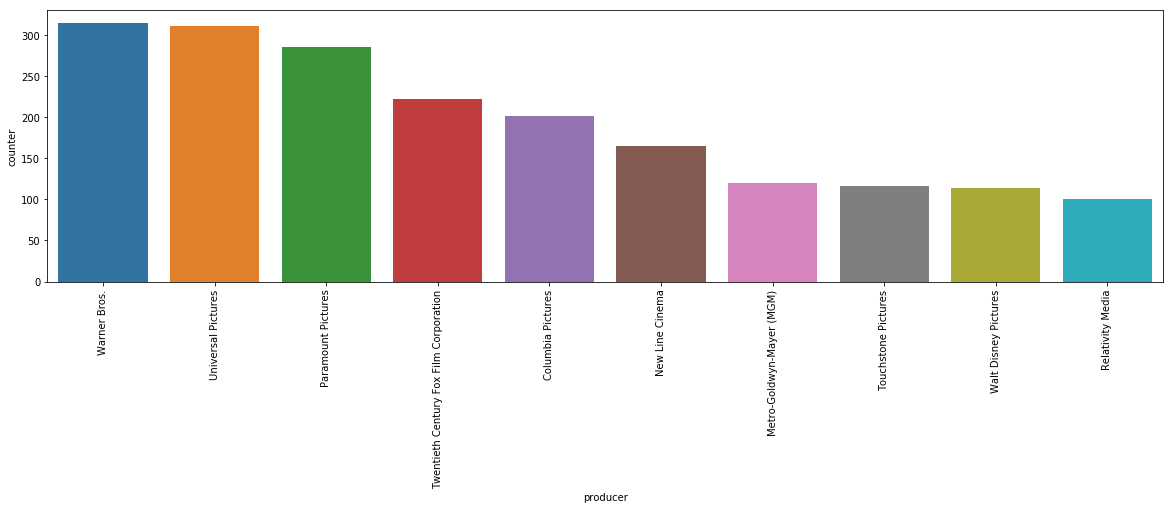

In [84]:
words = []
df_movies['production_companies'].apply(lambda x: words.extend(x))
words = ','.join(words)

common_producers = Counter(words.split(',')).most_common(10)
df_common_producers = pd.DataFrame(common_producers, columns=['producer', 'counter'])
plt.figure( figsize=(20,5) )
barplot = sns.barplot(x=df_common_producers['producer'], y=df_common_producers['counter'])
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
plt.show()

### Idiomas mais falados

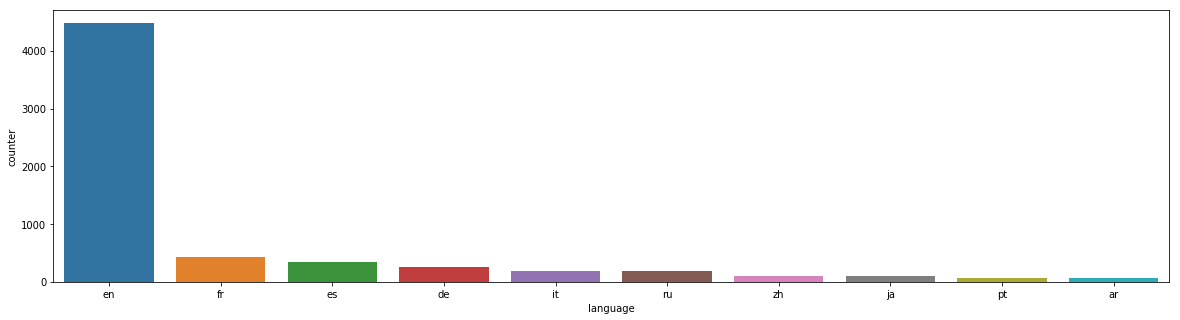

In [85]:
words = []
df_movies['spoken_languages'].apply(lambda x: words.extend(x))
words = ','.join(words)

common_languages = Counter(words.split(',')).most_common(10)
df_common_languages = pd.DataFrame(common_languages, columns=['language', 'counter'])
plt.figure( figsize=(20,5) )
barplot = sns.barplot(x=df_common_languages['language'], y=df_common_languages['counter'])
plt.show()

### Países que mais lançaram filmes

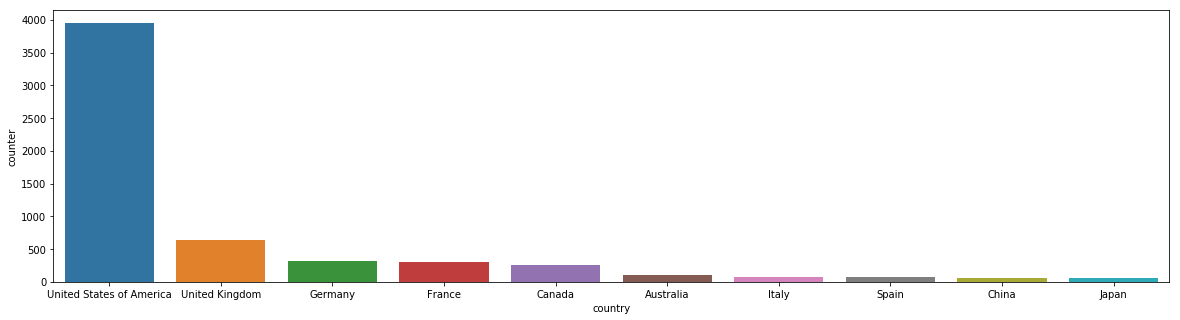

In [86]:
words = []
df_movies['production_countries'].apply(lambda x: words.extend(x))
words = ','.join(words)

common_countries = Counter(words.split(',')).most_common(10)
df_common_countries = pd.DataFrame(common_countries, columns=['country', 'counter'])
plt.figure( figsize=(20,5) )
barplot = sns.barplot(x=df_common_countries['country'], y=df_common_countries['counter'])
plt.show()

## Conclusão

A partir da base de filmes do TMDB, foi possível extrair algumas informações interessantes a respeito dos filmes e gostos das pessoas que assistem filmes. Foi verificado que Steven Spielberg foi o diretor que mais dirigiu filmes, com 27 filmes, seguido por Woody Allen, com 21. Já entre os atores, Samuel L. Jackson foi o que mais atuou, com 58 filmes, seguido por Robert De Niro, com 55, e Morgan Freeman, com 46. As maiores produtoras de filmes estão a Warner Bross, Universal Pictures e a Paramount Pictures.

O país que mais produziu filmes foi, disparado, os Estados Unidos, seguido pela inglaterra, alemanha e frança. Consequente, o inglês é o idioma mais falado nos filmes. Em seguida, vem francês, espanhol e alemão. 

Foi possível analisar alguns aspectos financeiros também. Foi observado uma certa relação linear entre receita e custo do filme. Os filmes que custaram mais dinheiro, apresentaram maior receita de maneira geral. Outra linearidade que foi observada também foi em relação à popularidade e receita. Os filmes mais populares faturaram mais. Em uma análise entre o tempo do filme e custo de produção, não foi possível observar uma relação linear entre essas variáveis.

Com relação aos gêneros dos filmes, aventura, ação e ficção científica lideram a lista entre os 30 filmes mais populares. Foi observado que não há uma relação direta entre popularidade e tempo de filme.

Por último, as palavras chave que mais aparecem nos filmes foram "independent film", "based novel" e "woman director".